## 파이썬 스테레오 비전으로 이미지의 심도 알아보기
---
자율주행자동차는 물론, 요즘에는 대부분의 스마트폰에도 카메라를 여러대 탑재하는게 당연한 시대입니다. 카메라를 여러대 장착하는 것은 다양한 이유가 있지만, 대표적으로 이미지의 심도(깊이, depth) 정보를 손쉽게 구하기 위함이지요. 이건 간단히 표현해서, 우리가 한쪽 눈으로 봤을때보다 양쪽 눈으로 봤을때 거리감이 더욱 잘 살아나는 것을 생각하면 됩니다. 이렇게 여러개의 카메라 (Stereo camera) 를 이용해 심도 정보를 알아내는 기술을 스테레오 비전 (Stereo Vision) 이라고 하는데요, 파이썬(Python)을 이용하면 스테레오 비전 계산을 손쉽게 할 수 있습니다. OpenCV 패키지를 이용해서 말이죠.  
</p></br></br>


이 글은 OpenCV 공식 문서 중 [\<Depth Map from Stereo Images\>](https://docs.opencv.org/4.x/dd/d53/tutorial_py_depthmap.html)를 번역 및 재구성해서 작성했습니다.  
</p></br></br>


### OpenCV
---
OpenCV 패키지는 파이썬에서 이미지를 처리하는 다양한 기능을 제공합니다. 대표적으로, `imread()` 함수를 사용해서 이미지 파일을 array 형식으로 불러올 수 있지요. 이렇게 불러온 이미지는. x축과 y축, 그리고 컬러 사진의 경우 RGB 정보를 포함해 3차원 배열로 처리할 수 있게 됩니다. 흑백 이미지라면 색상 축이 빠져서 2차원이 되겠지요.  
</p></br></br>


파이썬에서 OpenCV 패키지를 설치하는 방법은 `$ pip install opencv-python` 터미널 명령어를 입력하면 됩니다. OpenCV 패키지는 설치 및 불러오기를 할 때 패키지 이름이 일정하지 않다는 점을 기억해 두시기 바랍니다.  
</p></br></br>


이번에는 스테레오 카메라를 이용해 촬영한 샘플 사진 두 장 (tsukuba_l, tsukuba_r) 을 이용해서 이미지의 심도 정보를 알아보도록 하겠습니다. 별도 사진을 이용해서 실습을 해 보실 분들은, 스테레오 카메라를 이용해서 다양한 심도를 가진 사물을 촬영해 보시기 바랍니다. 또는 서로 똑같은 각도로 왼쪽, 오른쪽으로 살짝 이동한 상태에서 촬영한 사진을 준비해 주세요.  
</p></br></br>


<center><img src='./data/tsukuba/tsukuba_l.png'> <img src='./data/tsukuba/tsukuba_r.png'></p>왼쪽이 tsukuba_l, 오른쪽이 tsukuba_r 파일입니다.</center>
</p></br></br>



In [1]:
# 패키지 및 이미지 불러오기
import cv2 as cv
from matplotlib import pyplot as plt

# 흑백 사진은 imread 함수를 사용할 때 패러미터로 0을 입력하면 2차원으로 불러올 수 있습니다
imgL = cv.imread('./data/tsukuba/tsukuba_l.png', 0)
imgR = cv.imread('./data/tsukuba/tsukuba_r.png', 0)

</p></br></br>


### 이미지 시각화하기
---
파이썬은 기본적으로 사진을 불러오는 기능이 없습니다. OpenCV를 사용해서 불러왔다고 해도, array 자료형이기 때문에, 우리가 아는 사진의 형태로 확인할 수는 없지요. 그래서, 불러온 사진을 눈으로 확인하고 싶다면 파이썬의 대표적인 시각화 패키지인 맷플롯립 (matplotlib) 의 imshow 함수를 사용해서 시각화를 해볼 수 있습니다.  
</p></br></br>


맷플롯립에서 일반적인 그래프와 사진의 표현은 구조상 차이가 없습니다. 좌표에 따른 숫자값에 따라 색이 결정되는 방식으로 표현되지요. 단, 사진을 표현하는 imshow 함수의 특성상 그래프 좌표가 약간 바뀌는데요. 왼쪽 위가 (0,0)이며 오른쪽 아래로 갈수록 값이 커지는 형태입니다.  
</p></br></br>



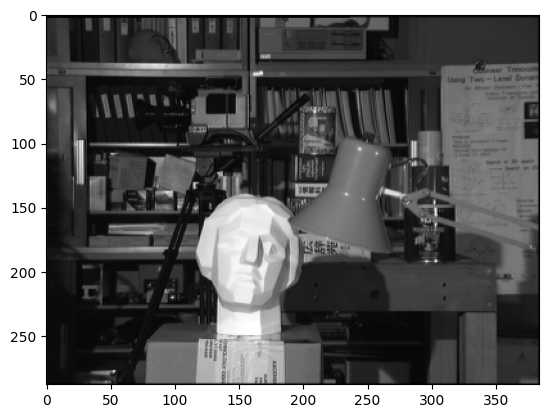

In [2]:
# imgL 시각화하기, 패러미터로 'gray'를 입력하면 흑백사진으로 표현된다
plt.imshow(imgL, 'gray')
plt.show()

### 스테레오 비전 실습해보기
---
이미지를 불러오고 시각화할 수 있으니, 이제는 스테레오 이미지를 이용해서 스테레오 비전 처리를 해보겠습니다. 이 때는, OpenCV 패키지에서 제공하는 StereoBM_create 함수를 사용합니다. StereoBM_create 함수는 numDisparities, blockSize라는 두 가지의 패러미터를 입력받는데요, 각 패러미터의 정보는 아래와 같습니다.  
</p></br></br>


<center><img src="https://docs.opencv.org/4.x/stereo_depth.jpg"></p>X: 피사체, O: 카메라1, O': 카메라2, z: 거리, f: 초점거리</center>
$$disparity = x − x′ = Bf/Z$$  
</p></br></br>


* numDisparities: 알고리즘에 사용될 disparity의 탐색 범위 (0부터 입력값까지) 를 이릅니다.
* blockSize: 가운데 픽셀을 기준으로 탐색하는 블록 크기를 결정합니다. 작을수록 더 정확한 정보를 제공하지만, 잘못된 계산을 할 가능성이 높아집니다. 홀수만 입력 가능.
</p></br></br>


이외에도 Stereo_BM 클래스에는 기타 패러미터가 있는데, 간단하게 번역하면 아래와 같으니 관심이 있는 분들은 OpenCV 공식 문서를 참조해 공부해 보시면 좋겠습니다.  
</p></br></br>


* texture_threshold: 두 이미지를 비교해서 텍스처가 충분하지 않은 영역을 필터링합니다.
* Speckle range and size: 블록 기반 매처는 종종 개체 경계 근처에 "반점"을 생성합니다. 이 때, matcher는 테이블에 투영된 텍스처에서 작은 가짜 심도 정보로 인식됩니다. 이러한 아티팩트를 제거하기 위해 speckle_size 및 speckle_range 매개변수로 제어되는 스페클 필터를 사용하여 후처리합니다. speckle_size는 disparity blob이 "반점"으로 무시되는 픽셀 수입니다. speckle_range는 동일한 blob의 일부로 간주되어야 하는 임계값을 제어합니다.
* Number of disparities: 슬라이딩 윈도우가 포함할 픽셀 수입니다. 클수록 가시적 깊이의 범위는 더 커지지만 더 많은 계산이 필요합니다.
* min_disparity: 탐색을 시작할 왼쪽 픽셀의 x 위치로부터의 오프셋.
* uniqueness_ratio: 사후 필터링 단계입니다. 최상의 일치 디스패리티가 검색 범위의 다른 모든 디스패리티보다 충분히 좋지 않으면 픽셀이 필터링됩니다.
* prefilter_size 및 prefilter_cap: 블록 일치에 대비하여 이미지 밝기를 정규화하고 텍스처를 향상시키는 사전 필터링 단계입니다. 일반적으로 이러한 항목을 조정할 필요가 없습니다.  
</p></br></br>


아래에는 OpenCV StereoBM 기능을 이용해서 스테레오 비전 기술을 시연해 보는 코드를 적어두었습니다. array 형태의 데이터는 이후 기계학습 또는 통계 계산 등에 이용할 수 있으며, 이를 시각화한다면 눈으로 심도 정보를 직접 확인할 수 있지요. 밝은 면 (숫자가 큰 부분) 의 경우 심도가 얕은 (상대적으로 가까운) 물체이며, 어두운 면 (숫자가 작은 부분) 의 경우 심도가 깊은 (상대적으로 먼) 물체입니다.  
</p></br></br>



In [3]:
# 스테레오 이미지 처리하기
stereo = cv.StereoBM_create(numDisparities=32, blockSize=21)
disparity = stereo.compute(imgL, imgR)

# 연산값은 array 형식으로 저장된다
disparity

array([[-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       ...,
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16]], dtype=int16)

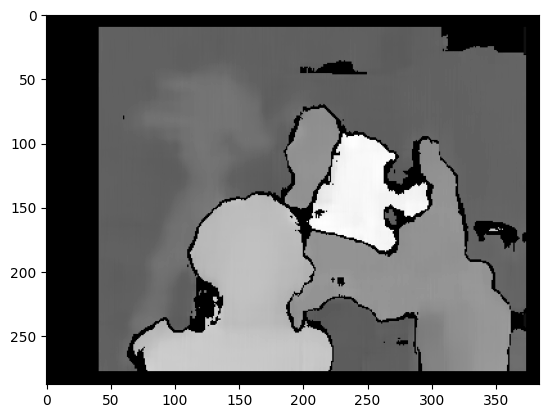

In [4]:
plt.imshow(disparity,'gray')
plt.show()